## Set-up: Import Required Notebook Libraries

In [57]:
from __future__ import unicode_literals, division
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (17, 10)

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 1  |  Loading Data </h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

In [58]:
dataset = "lab4_dataset"

Retrieve the dataset content S3 location and load it into a DataFrame object.

In [94]:
import boto3

# create IoT Analytics client
client = boto3.client('iotanalytics')

dataset_url = client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']
data = pd.read_csv(dataset_url)[["cos_emission", "max_co2_emission", "vehicle_id", "timestep"]].drop_duplicates(subset=["vehicle_id", "timestep"], keep="last")

In [105]:
for i in range(1, 6):
    max_co2 = 0
    for row in data[data["vehicle_id"] == i].sort_values("timestep").iterrows():
        max_co2 = max(max_co2, row[1]["cos_emission"])
        data.loc[row[0], "max_co2_emission"] = max_co2

In [106]:
data[data["vehicle_id"] == 1]

cos_emission  max_co2_emission  vehicle_id  timestep
1614      11866.12           23476.3         1.0     146.0
1615          0.00           23476.3         1.0     147.0
1616      11366.05           23476.3         1.0     148.0
1617          0.00           23476.3         1.0     149.0
1618       7719.27           23476.3         1.0     150.0
...            ...               ...         ...       ...
3505       6613.02           23476.3         1.0     141.0
3506          0.00           23476.3         1.0     142.0
3507          0.00           23476.3         1.0     143.0
3508          0.00           23476.3         1.0     144.0
3509          0.00           23476.3         1.0     145.0

[258 rows x 4 columns]

<Axes: xlabel='timestep', ylabel='max_co2_emission'>

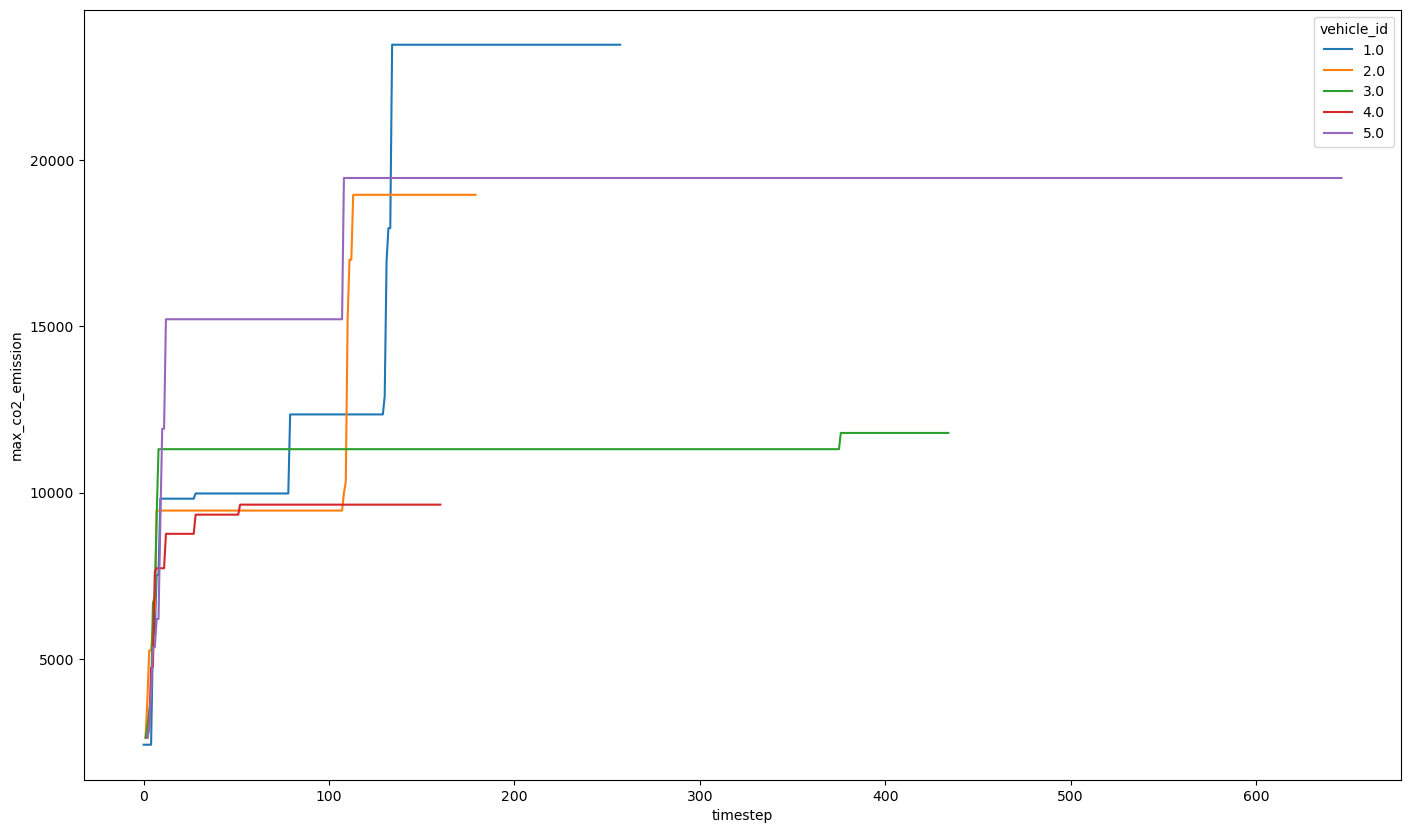

In [113]:
sns.lineplot(data=data, x='timestep', y='max_co2_emission', hue='vehicle_id', palette='tab10')

<Axes: xlabel='timestep', ylabel='cos_emission'>

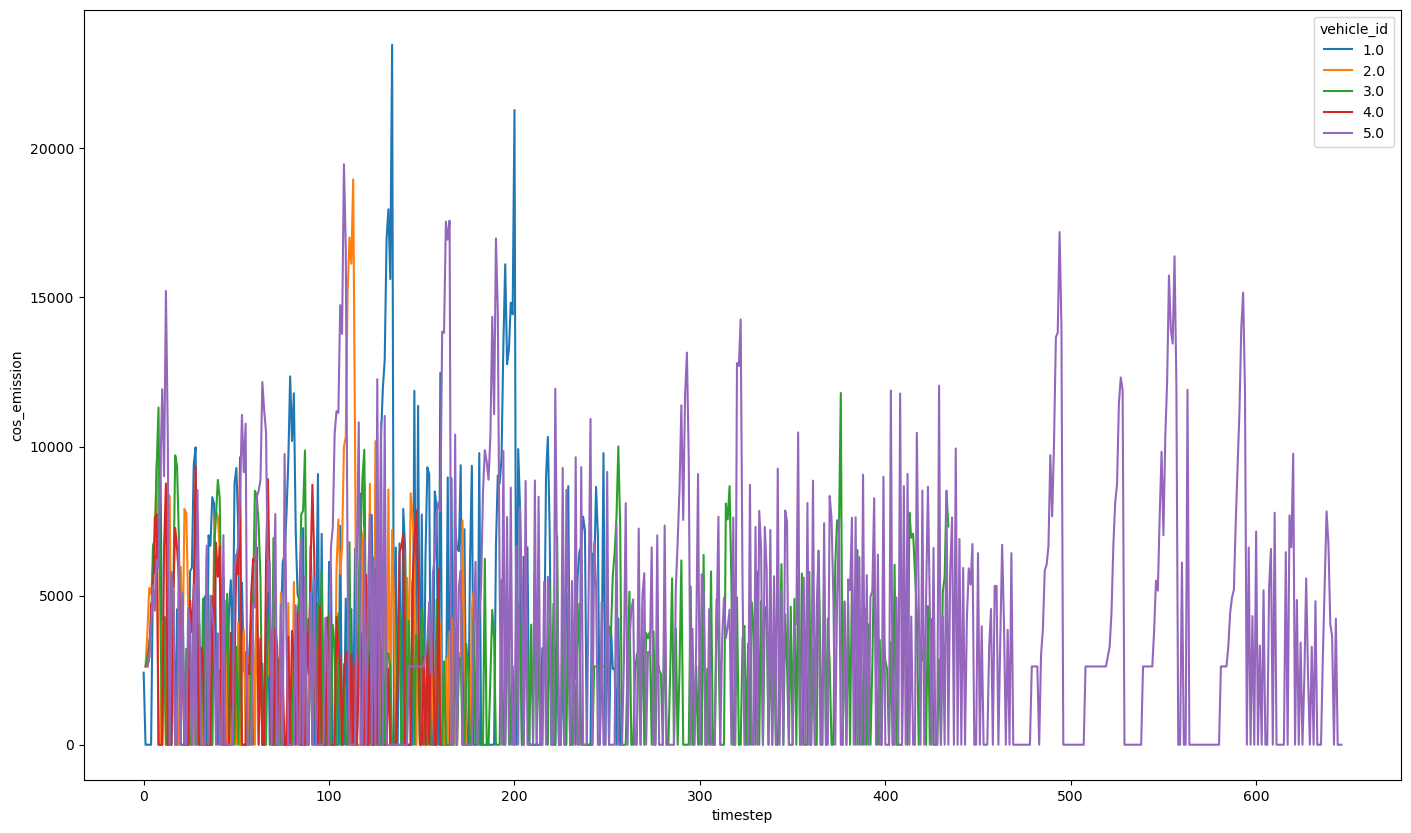

In [115]:
sns.lineplot(data=data, x='timestep', y='cos_emission', hue='vehicle_id', palette='tab10')

<Axes: xlabel='timestep'>

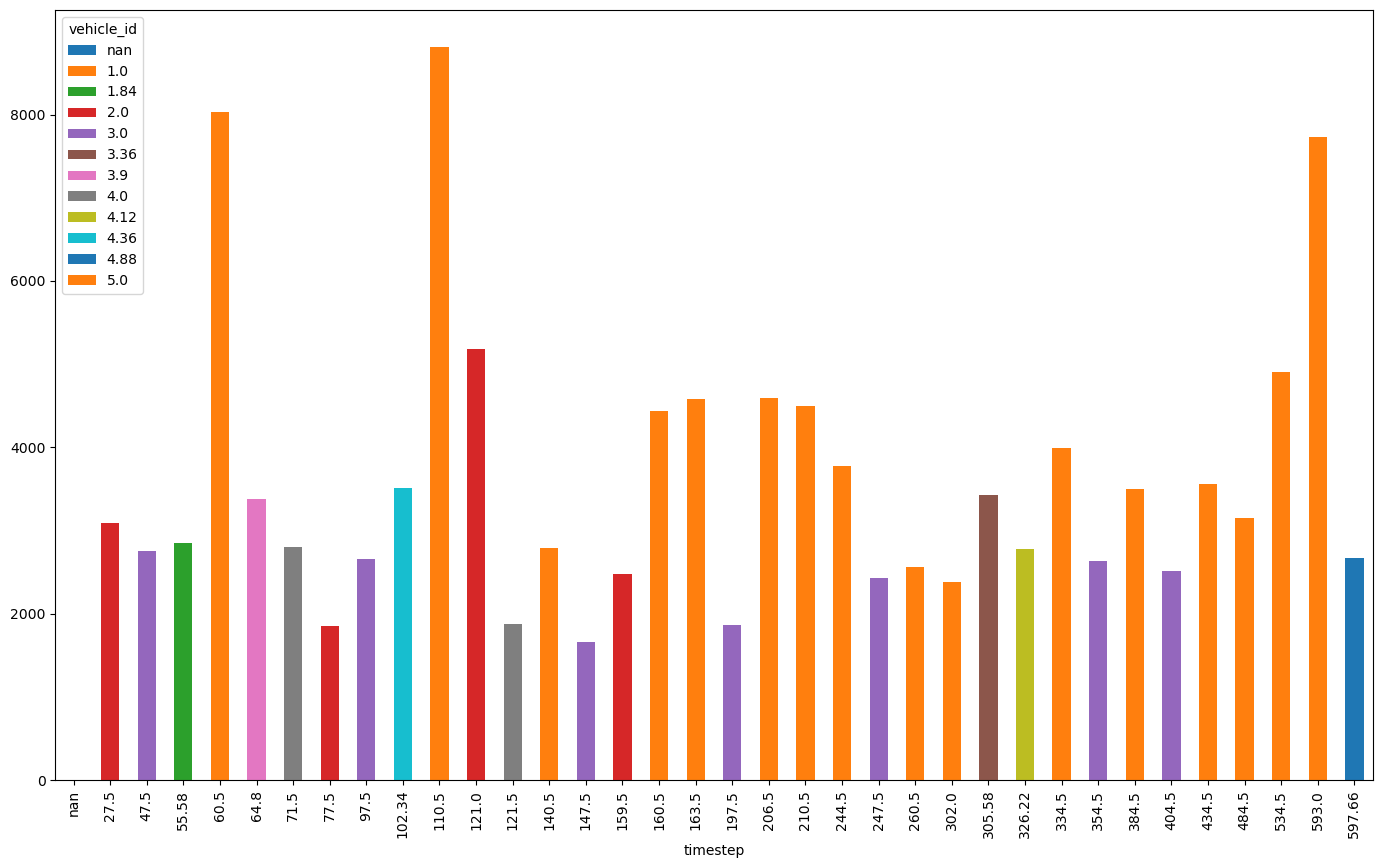

In [122]:
pivot_data = data.groupby(data.index // 50).mean()
pivot_data = pivot_data.pivot(index='timestep', columns='vehicle_id', values='cos_emission').fillna(0)
pivot_data.plot(kind='bar', stacked=True)

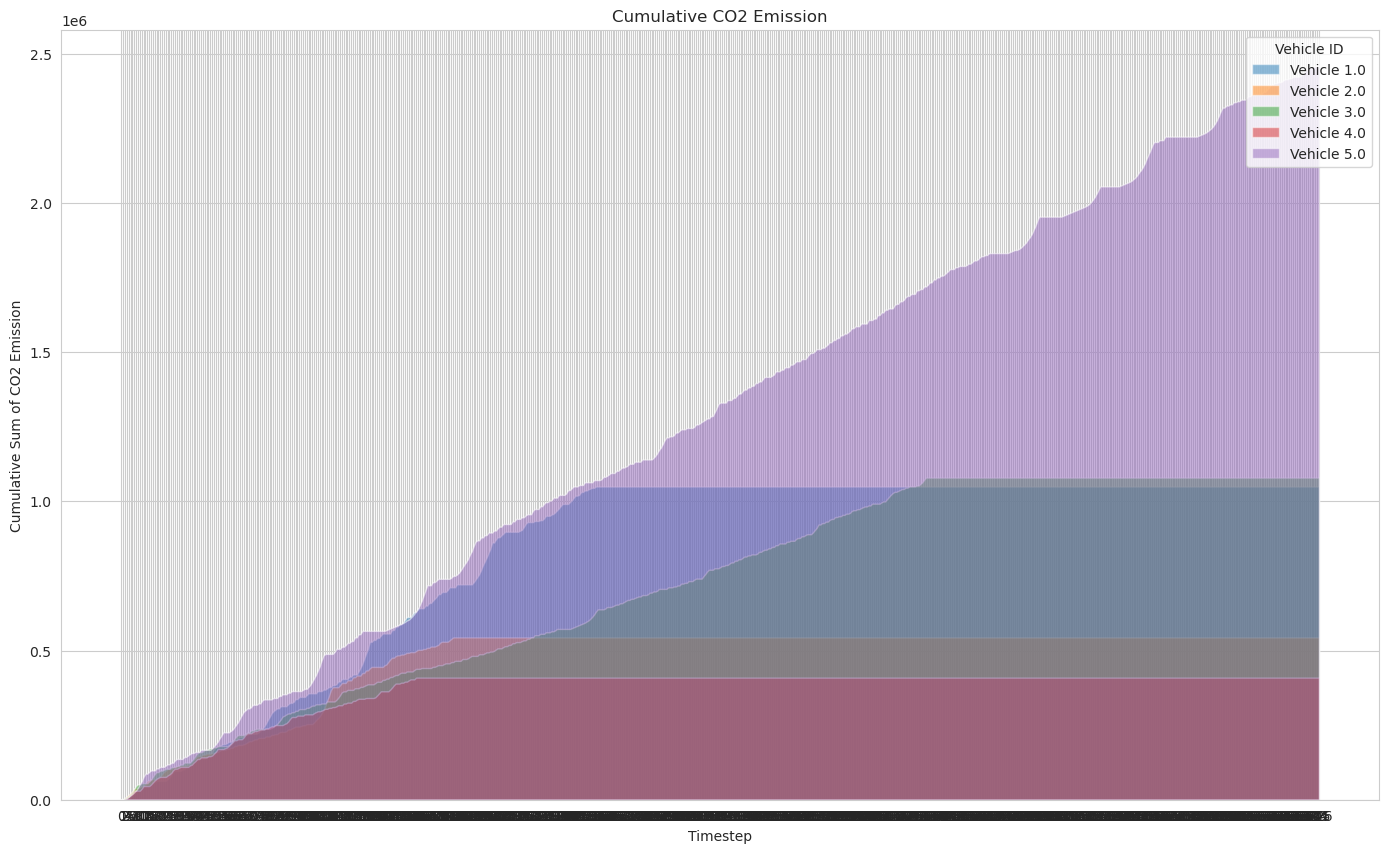

In [144]:
cumulative_df = data.groupby(['timestep', 'vehicle_id'])['cos_emission'].sum().unstack().fillna(0).cumsum()

timesteps = cumulative_df.index
for vehicle_id in cumulative_df.columns:
    plt.stackplot(timesteps, cumulative_df[vehicle_id], labels=[f'Vehicle {vehicle_id}'], alpha=0.5)

plt.title('Cumulative CO2 Emission')
plt.xlabel('Timestep')
plt.ylabel('Cumulative Sum of CO2 Emission')
plt.xticks(timesteps)  # Set x-axis ticks to match timesteps
plt.grid(True)
plt.legend(title='Vehicle ID')
plt.show()